In [13]:
%cd /Users/helloworld/Home/Desktop/amugeona/LNS_floating/

/Users/helloworld/Home/Desktop/amugeona/LNS_floating


# Fluid surface dynamics

Based on: "Non-wetting impact of a sphere onto a bath and its application to bouncing droplets" by Galeano-Rios, Milewski, and Vanden-Broeck (2017)

Included forces:
- Gravity effects (Froude number)
- Surface tension (Weber number)
- Viscous dissipation (Reynolds number)

Notations:
- η: surface elevation
- ϕ: velocity potential
- w³: vertical vortical component


Key equations (2.15) from the paper:
- (2.15a): Laplace equation for velocity potential  
  
  $\Delta \phi = 0$

- (2.15b): vortical component evolution  
  
  $w_t^i = \frac{1}{Re} \Delta w^i$

- (2.15c): surface elevation evolution  
  
  $\eta_t = \phi_z + w^3$

- (2.15d): potential evolution at surface  
  
  $\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_{H} \phi - p_s$

- (2.15e): vertical vortical component at surface  
  
  $w_t^3 = \frac{2}{Re} \Delta_H\left(\phi_z + w^3\right)$

- (2.17): $w^3 = \frac{2}{Re} \Delta_{H} \eta,\quad z = 0$
  

Boundary conditions (same as heat/Laplace solvers):
- Top ($z = D$): Surface with Dirichlet-like BC ($n$ determines location)
- Bottom ($z = 0$): non-slip BC ($\partial u/\partial z + w^3 = 0$)
- Left & Right: Periodic BC





In [14]:
import numpy as np
from scipy.sparse import lil_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
import math

In [15]:
import session_info
session_info.show()

#### Setting up constants

In [16]:
# physical params
L_in_cm = 50.0 # length in x-dir (cm)
D_in_cm = 5.0 # depth in z-dir (cm)
g_accel = 980.0 # gravitational acceleration (cm/s^2)
sigma = 74.9 # surface tension (dyne/cm)
rho = 1.0 # density (g/cm^3)
nu = 0.00894 # kinematic viscosity (cm^2/s)

# non-dimensionalization
Unit_length = 2.5
Unit_time = 0.05 # adjust....
Unit_velocity = Unit_length / Unit_time

# Numerical parameters
nx = 400 # n grid points in x-dir
nz = 100 # n grid points in z-dir
nt = 5000 # n time steps
total_time = 3.0 # seconds

# dimensionless params
L = L_in_cm / Unit_length
D = D_in_cm / Unit_length
T_total = total_time / Unit_time

# dimensionless numbers (eqn 2.14 in Galeano-Rios et al. 2017)
# Fr = V^2/(gL), We = ρV^2L/σ, Re = LV/ν
Fr = (Unit_velocity**2) / (g_accel * Unit_length)
We = (rho * (Unit_velocity**2) * Unit_length) / sigma
Re = (Unit_velocity * Unit_length) / nu

print(f"Dimless params: Froude number, Weber number, Reynolds number")
print(f"Fr: {Fr:.4f}, We: {We:.4f}, Re: {Re:.4f}")

# derived numerical constants
dx = L / nx
dz = D / nz
dt = T_total / nt

print(f"  Froude number Fr = V²/(gL) = {Fr:.4f}")
print(f"  Weber number  We = ρV²L/σ  = {We:.4f}")
print(f"  Reynolds number Re = VL/ν  = {Re:.2f}")
print(f"\nGrid: {nx} x {nz} points, dt = {dt:.6f}")


Dimless params: Froude number, Weber number, Reynolds number
Fr: 1.0204, We: 83.4446, Re: 13982.1029
  Froude number Fr = V²/(gL) = 1.0204
  Weber number  We = ρV²L/σ  = 83.4446
  Reynolds number Re = VL/ν  = 13982.10

Grid: 400 x 100 points, dt = 0.012000


#### Initial and boundary settings

In [17]:
  
def initial_eta(x):
    """
    Initial surface elevation, just changed from sin/cos to gaussian bump
    """
    x0 = L/2 # center of the domain
    sigma_x = L/10 # width
    amplitude = 0.1 # small but visible
    return amplitude * np.exp(-(x-x0)**2 / (2*sigma_x**2))


In [18]:
# Index conversion func

def to_1d_index(i, j):
    """
    Convert 2D grid indices to 1D array index
    """
    return i * nx + j

def to_2d_index(idx):
    """
    Convert 1D array index to 2D grid indices (i, j)
    """
    i = idx // nx
    j = idx % nx
    return i, j
    

#### Arry initialization

In [19]:
# main things
eta = np.zeros(nx) # surf elevation η(x, t)
phi = np.zeros((nz, nx)) # velocity potential ϕ(x, z, t)
w3 = np.zeros((nz, nx)) # vertical vortical component w^3(x, t), it's now 2d field (was 1d in 01_Surface_Dynamics)
w1 = np.zeros((nz, nx)) # horizontal vortical component

x_vec = np.linspace(0, L, nx, endpoint=False)
z_vec = np.linspace(0, D, nz)

for j in range(nx):
    eta[j] = initial_eta(x_vec[j])


#### Operators

In [20]:
def build_Delta_H(n, dx):
    """Horizontal Laplacian for periodic BC"""
    D = lil_matrix((n, n))
    for j in range(n):
        D[j, j] = -2.0 / dx**2
        D[j, (j+1) % n] = 1.0 / dx**2
        D[j, (j-1) % n] = 1.0 / dx**2
    return D.tocsr()

def build_Laplace_matrix_nonslip(nx_l, nz_l, dx_l, dz_l):
    """
    Build matrix for Δϕ = 0 with BCs
    
    MODIFIED: Bottom BC is now non-slip (∂φ/∂z = -w^3) instead of Neumann
    - Top: Dirichlet (φ = φ_surface, handled in RHS)
    - Bottom: ∂φ/∂z = -w^3 (non-slip, handled via ghost point in RHS)
    - Left/Right: Periodic
    """
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    alpha = (dz_l / dx_l)**2
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            
            # Laplacian coefficients
            A[idx, idx] = -2 * alpha - 2
            
            # x-neighbors (periodic)
            A[idx, i * nx_l + (j + 1) % nx_l] = alpha
            A[idx, i * nx_l + (j - 1) % nx_l] = alpha
            
            # z-neighbors
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = 1
            else:
                # Bottom: non-slip BC (∂φ/∂z = -w³)
                # Ghost point: φ_{-1} = φ_1 - 2*dz*w³
                # This doubles coefficient for φ_1, RHS gets -2*dz*w³ contribution
                A[idx, (i + 1) * nx_l + j] = 2
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = 1
            # Top: Dirichlet handled in RHS
    
    return A.tocsr()

def build_heat_matrix_2d(nx_l, nz_l, dx_l, dz_l):
    """
    NEW: Build 2D Laplacian for heat equation (w³ and w¹ evolution)
    
    BCs:
    - Periodic in x
    - Neumann at top and bottom (∂w/∂z = 0) for interior solve
      (actual BCs applied separately after solve)
    """
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    
    coeff_x = 1.0 / (dx_l**2)
    coeff_z = 1.0 / (dz_l**2)
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            
            A[idx, idx] = -2.0 * coeff_x - 2.0 * coeff_z
            
            # x-neighbors (periodic)
            A[idx, i * nx_l + (j + 1) % nx_l] = coeff_x
            A[idx, i * nx_l + (j - 1) % nx_l] = coeff_x
            
            # z-neighbors with Neumann BC at boundaries
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i + 1) * nx_l + j] += coeff_z  # Ghost point at bottom
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i - 1) * nx_l + j] += coeff_z  # Ghost point at top
    
    return A.tocsr()

def curvature(eta, dx):
    """Compute κ[η] = ∂²η/∂x² (linearized)"""
    kappa = np.zeros_like(eta)
    n = len(eta)
    for j in range(n):
        kappa[j] = (eta[(j+1)%n] - 2*eta[j] + eta[(j-1)%n]) / dx**2
    return kappa

# Build matrices
Delta_H = build_Delta_H(nx, dx)
A_laplace = build_Laplace_matrix_nonslip(nx, nz, dx, dz)
Laplacian_2d = build_heat_matrix_2d(nx, nz, dx, dz)
I_1d = eye(nx, format='csr')
I_2d = eye(nx*nz, format='csr')

# Implicit Euler matrix for surface φ
A_phi_surf = I_1d - (2.0 * dt / Re) * Delta_H

# Implicit Euler matrix for η
A_eta = I_1d - (2.0 * dt / Re) * Delta_H

# Implicit Euler matrix for heat eqn (w^3, w^1)
# w_t = (1/Re) Δ w -> (I - dt/Re *  Δ) w^{n+1} = w^n
A_heat = I_2d - (dt/Re) * Laplacian_2d

#### Laplace eqn solver for ϕ: eqn (2.15a)

#### system matrices

#### Time

1. Step 1: Evolve w^3 using heat eqn (2.15b)
   
   $w^{3}_{t} = (1/Re) \Delta w^3 $ 
   
   Then apply BCs:

   - Top (surface): w³ = (2/Re) Δ_H η  from (2.17)

   - Bottom (non-slip): w³ = -∂φ/∂z

   Then evolve w^1 using heat eqn (2.15b)

2. Step 2: Update ϕ at surface using (2.15d)
   
   $\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_H \phi - p_s$

   $p_s = 0$ (no solid impact)

   Using implicit Euler:

   $ \left( I - \frac{2 \Delta t}{Re} \Delta_H \right) \varphi^{n+1} = \varphi^n - \frac{\Delta t}{Fr} \eta + \frac{\Delta t}{We} \kappa[\eta] $

3. Step 3: Solve Laplace eqn for ϕ in entire domain with new op boundary cond

4. Step 4: update surface elevation η using equation (2.15c)

   $\eta_t = \phi_z + w^3 \quad \text{at} \quad z = 0$

   Using (2.17): $w^3 = \frac{2}{Re} \Delta_H \eta$

   $\eta_t = \phi_z + \frac{2}{Re} \Delta_H \eta$

   Implicit euler:

   $(\eta^{k+1} - \eta^k)/\delta t = \phi_z^{k+1} + \frac{2}{Re} \Delta_H \eta^{k+1}$

   $\eta^{k+1} - \frac{2\delta t}{Re} \Delta_H \eta^{k+1} = \eta^k + \delta t\, \phi_z^{k+1}$

   $(I - \frac{2\delta t}{Re} \Delta_H) \eta^{k+1} = \eta^k + \delta t\, \phi_z^{k+1}$


In [21]:
%%time
print(f"Total steps: {nt}")

# backup for viz
eta_history = []
phi_history = []
w3_history = []
w1_history = []
time_points = []
save_every = max(1, nt//100)

# time loop
for n in range(nt):
    # t_current = n*delta_t
    # t_next = (n+1)*delta_t

    #! Step 1 ===#
    #* w³ evolution
    
    w3_flat = w3.flatten()
    w3_new_flat = spsolve(A_heat, w3_flat)
    w3_new = w3_new_flat.reshape((nz, nx))
    
    # Top BC (i=nz-1): from (2.17), w³ = (2/Re) Δ_H η at surface
    w3_new[-1, :] = (2.0 / Re) * Delta_H.dot(eta)
    
    # Bottom BC (i=0): non-slip means u_z = ∂φ/∂z + w³ = 0, so w³ = -∂φ/∂z
    phi_z_bottom = (phi[1, :] - phi[0, :]) / dz
    w3_new[0, :] = -phi_z_bottom

    #* w¹ evolution
    w1_flat = w1.flatten()
    w1_new_flat = spsolve(A_heat, w1_flat)
    w1_new = w1_new_flat.reshape((nz, nx))

    # Bottom BC for w^1: non-slip means u_x = ∂φ/∂x + w¹ = 0, so w¹ = -∂φ/∂x
    for j in range(nx):
        phi_x_bottom = (phi[0, (j+1)%nx] - phi[0, (j-1)%nx]) / (2*dx)
        w1_new[0, j] = -phi_x_bottom

    #! Step 2 ===#

    # curvature
    kappa_eta = curvature(eta, dx)

    # current ϕ at top surface
    phi_surf = phi[-1, :].copy()

    b_phi = phi_surf - (dt / Fr) * eta + (dt / We) * kappa_eta
    phi_surf_new = spsolve(A_phi_surf, b_phi)

    #! Step 3 ===#

    b_laplace = np.zeros(nx * nz)
    for j in range(nx):
        b_laplace[(nz-1)*nx + j] = -phi_surf_new[j]
    

    # updated: bottom non-slip BC
    # ∂φ/∂z = -w³ at bottom, ghost point gives: φ_{-1} = φ_1 - 2*dz*w³
    # RHS contribution: -2 * dz * w³[0, j] (sign)
    for j in range(nx):
        b_laplace[j] += -2.0 * dz * w3_new[0, j]
    
    phi_vec = spsolve(A_laplace, b_laplace)
    phi_new = phi_vec.reshape((nz, nx))

    #! Step 4 ===#

    phi_z_surf = (phi_new[-1, :] - phi_new[-2, :]) / dz
    w3_surf = w3_new[-1, :]
    
    b_eta = eta + dt * (phi_z_surf + w3_surf)
    eta_new = spsolve(A_eta, b_eta)
    
    #! var update for next iteration
    eta = eta_new.copy()
    phi = phi_new.copy()
    w3 = w3_new.copy()
    w1 = w1_new.copy()
    
    #! Save for viz
    if n % save_every == 0:
        eta_history.append(eta.copy())
        phi_history.append(phi.copy())
        w3_history.append(w3[-1, :].copy())  # Save surface w³ for compatibility
        w1_history.append(w1[0, :].copy())  # Save bottom w¹ for compatibility
        time_points.append((n + 1) * dt * Unit_time)
    
    #! progress bar
    if (n+1) % (nt//10) == 0:
        print(f"  {100*(n+1)/nt:3.0f}% complete | t = {(n+1)*dt*Unit_time:.3f}s | "
              f"max|η| = {np.max(np.abs(eta)):.6f}")



Total steps: 5000
   10% complete | t = 0.300s | max|η| = 0.005908
   20% complete | t = 0.600s | max|η| = 0.000389
   30% complete | t = 0.900s | max|η| = 0.000026
   40% complete | t = 1.200s | max|η| = 0.000002
   50% complete | t = 1.500s | max|η| = 0.000000
   60% complete | t = 1.800s | max|η| = 0.000000
   70% complete | t = 2.100s | max|η| = 0.000000
   80% complete | t = 2.400s | max|η| = 0.000000
   90% complete | t = 2.700s | max|η| = 0.000000
  100% complete | t = 3.000s | max|η| = 0.000000
CPU times: user 25min 7s, sys: 4min 36s, total: 29min 43s
Wall time: 27min 35s


#### Velocity field compute

- Velocity $u = \mathbf{u} = \nabla \phi + w$
- $u_x = \frac{\partial \phi}{\partial x} + w^1$
- $u_z = \frac{\partial \phi}{\partial z} + w^3$

In [22]:
u_x = np.zeros((nz, nx)) # horizontal velocity
u_z = np.zeros((nz, nx)) # vertical velocity

In [23]:
# compute ∂ϕ/∂x
for i in range(nz):
    for j in range(nx):
        # u_x = ∂φ/∂x + w¹ (UPDATED: added w¹)
        u_x[i, j] = (phi[i, (j + 1) % nx] - phi[i, (j - 1) % nx]) / (2 * dx) + w1[i, j]
        
        # u_z = ∂φ/∂z + w³ (UPDATED: added w³)
        if i == 0:
            u_z[i, j] = (phi[i + 1, j] - phi[i, j]) / dz + w3[i, j]
        elif i == nz - 1:
            u_z[i, j] = (phi[i, j] - phi[i - 1, j]) / dz + w3[i, j]
        else:
            u_z[i, j] = (phi[i + 1, j] - phi[i - 1, j]) / (2 * dz) + w3[i, j]

#### dataviz

In [24]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['axes.grid'] = False  # Remove the gray grid
import seaborn as sns
sns.set_style("white")  # Use white style without grid

import os

/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_22538/184592678.py:104: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_22538/184592678.py:104: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_22538/184592678.py:105: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.savefig('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.png', dpi=300, bbox_inches='tight')
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_22538/184592678.py:105: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.savefig('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.png', dpi=300, bbox_inches='tight')


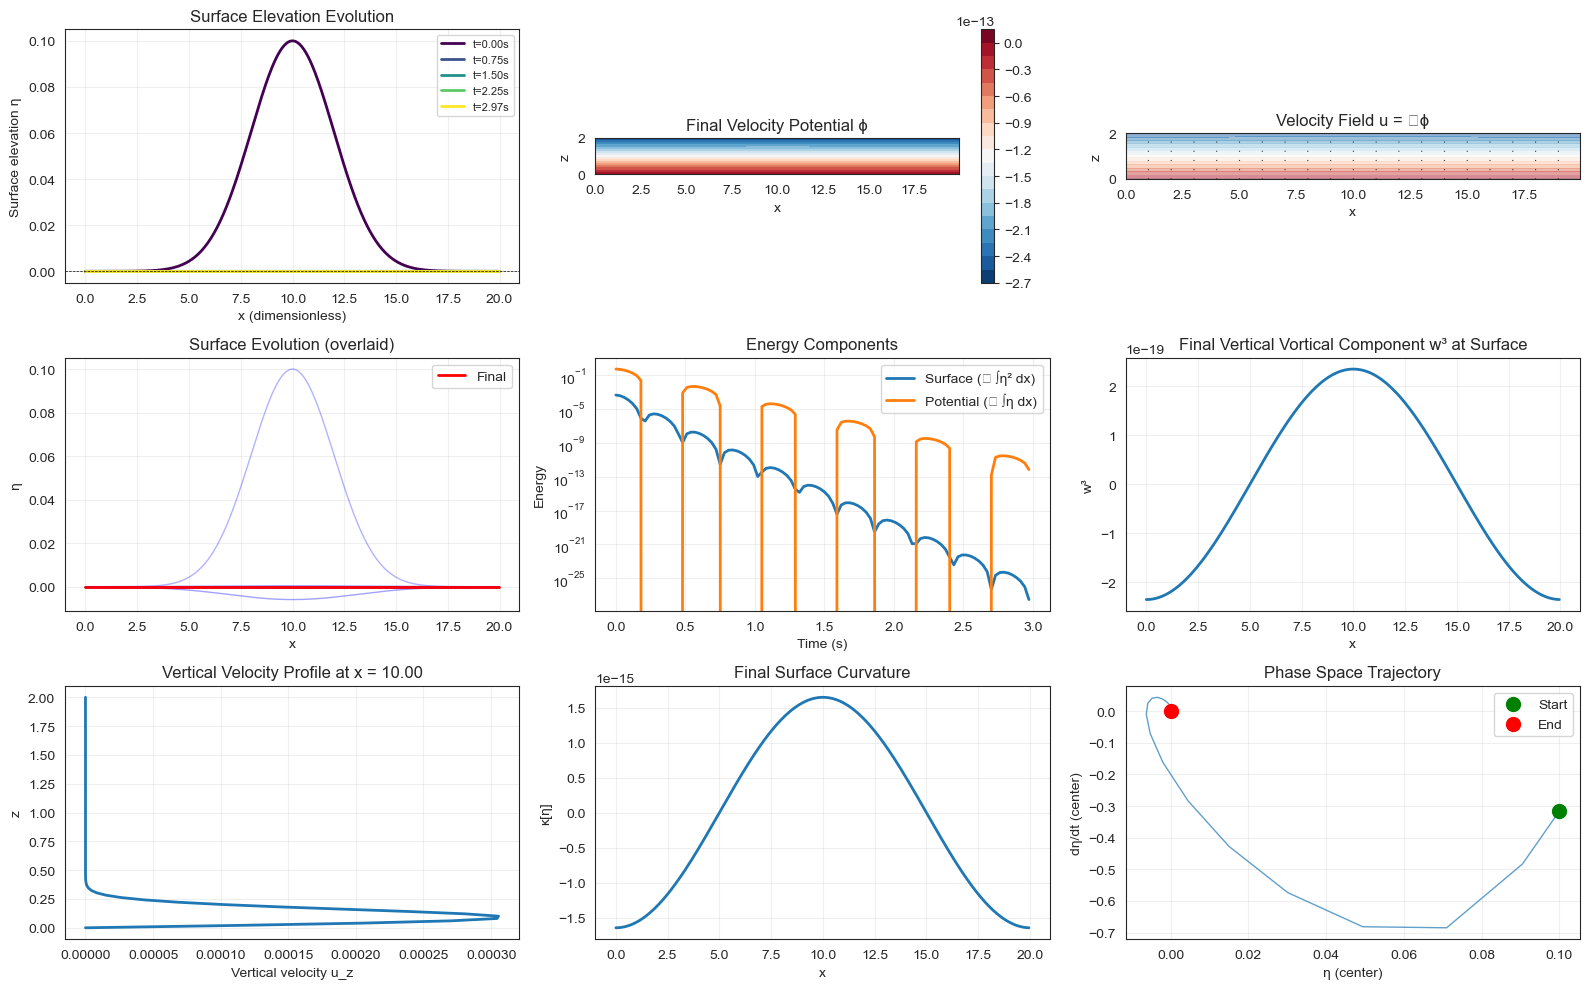

In [26]:
X, Z = np.meshgrid(x_vec, z_vec)

fig = plt.figure(figsize=(16, 10))

#! 1. Surface evolution
ax1 = fig.add_subplot(3, 3, 1)
times_to_plot = [0, len(eta_history)//4, len(eta_history)//2, 3*len(eta_history)//4, -1]
colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))
for idx, color in zip(times_to_plot, colors):
    ax1.plot(x_vec, eta_history[idx], label=f't={time_points[idx]:.2f}s', 
             linewidth=2, color=color)
ax1.set_xlabel('x (dimensionless)')
ax1.set_ylabel('Surface elevation η')
ax1.set_title('Surface Elevation Evolution')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.5)

#! 2. Final velocity potential
ax2 = fig.add_subplot(3, 3, 2)
c2 = ax2.contourf(X, Z, phi, levels=20, cmap='RdBu_r')
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('Final Velocity Potential ϕ')
ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2)

#! 3. Velocity field
ax3 = fig.add_subplot(3, 3, 3)
skip = max(1, nx//20)
ax3.contourf(X, Z, phi, levels=15, cmap='RdBu_r', alpha=0.5)
Q = ax3.quiver(X[::skip, ::skip], Z[::skip, ::skip],
               u_x[::skip, ::skip], u_z[::skip, ::skip],
               scale=10, alpha=0.8, width=0.003)
ax3.set_xlabel('x')
ax3.set_ylabel('z')
ax3.set_title('Velocity Field u = ∇ϕ')
ax3.set_aspect('equal')

#! 4. Surface at different times
ax4 = fig.add_subplot(3, 3, 4)
for idx in range(0, len(eta_history), len(eta_history)//10):
    alpha = 0.3 + 0.7 * idx / len(eta_history)
    ax4.plot(x_vec, eta_history[idx], alpha=alpha, color='blue', linewidth=1)
ax4.plot(x_vec, eta_history[-1], color='red', linewidth=2, label='Final')
ax4.set_xlabel('x')
ax4.set_ylabel('η')
ax4.set_title('Surface Evolution (overlaid)')
ax4.legend()
ax4.grid(True, alpha=0.3)

#! 5. Energy
ax5 = fig.add_subplot(3, 3, 5)
surface_energy = [(1/We)*np.sum(e**2)*dx for e in eta_history]
potential_energy = [(1/Fr)*np.sum(e)*dx for e in eta_history]
ax5.plot(time_points, surface_energy, label='Surface (∝ ∫η² dx)', linewidth=2)
ax5.plot(time_points, potential_energy, label='Potential (∝ ∫η dx)', linewidth=2)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Energy')
ax5.set_title('Energy Components')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

#! 6. w^3 evolution
ax6 = fig.add_subplot(3, 3, 6)
ax6.plot(x_vec, w3[-1, :], linewidth=2, label='Final w³')
ax6.set_xlabel('x')
ax6.set_ylabel('w³')
ax6.set_title('Final Vertical Vortical Component w³ at Surface')
ax6.grid(True, alpha=0.3)

#! 7. Centerline velocity
ax7 = fig.add_subplot(3, 3, 7)
j_center = nx // 2
ax7.plot(u_z[:, j_center], z_vec, linewidth=2)
ax7.set_ylabel('z')
ax7.set_xlabel('Vertical velocity u_z')
ax7.set_title(f'Vertical Velocity Profile at x = {x_vec[j_center]:.2f}')
ax7.grid(True, alpha=0.3)

#! 8. Surface curvature
ax8 = fig.add_subplot(3, 3, 8)
kappa_final = curvature(eta, dx)
ax8.plot(x_vec, kappa_final, linewidth=2)
ax8.set_xlabel('x')
ax8.set_ylabel('κ[η]')
ax8.set_title('Final Surface Curvature')
ax8.grid(True, alpha=0.3)

#! 9. Phase space
ax9 = fig.add_subplot(3, 3, 9)
eta_center = [e[nx//2] for e in eta_history]
deta_center = np.gradient(eta_center, time_points[1] - time_points[0])
ax9.plot(eta_center, deta_center, linewidth=1, alpha=0.7)
ax9.scatter(eta_center[0], deta_center[0], c='green', s=100, label='Start', zorder=5)
ax9.scatter(eta_center[-1], deta_center[-1], c='red', s=100, label='End', zorder=5)
ax9.set_xlabel('η (center)')
ax9.set_ylabel('dη/dt (center)')
ax9.set_title('Phase Space Trajectory')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()


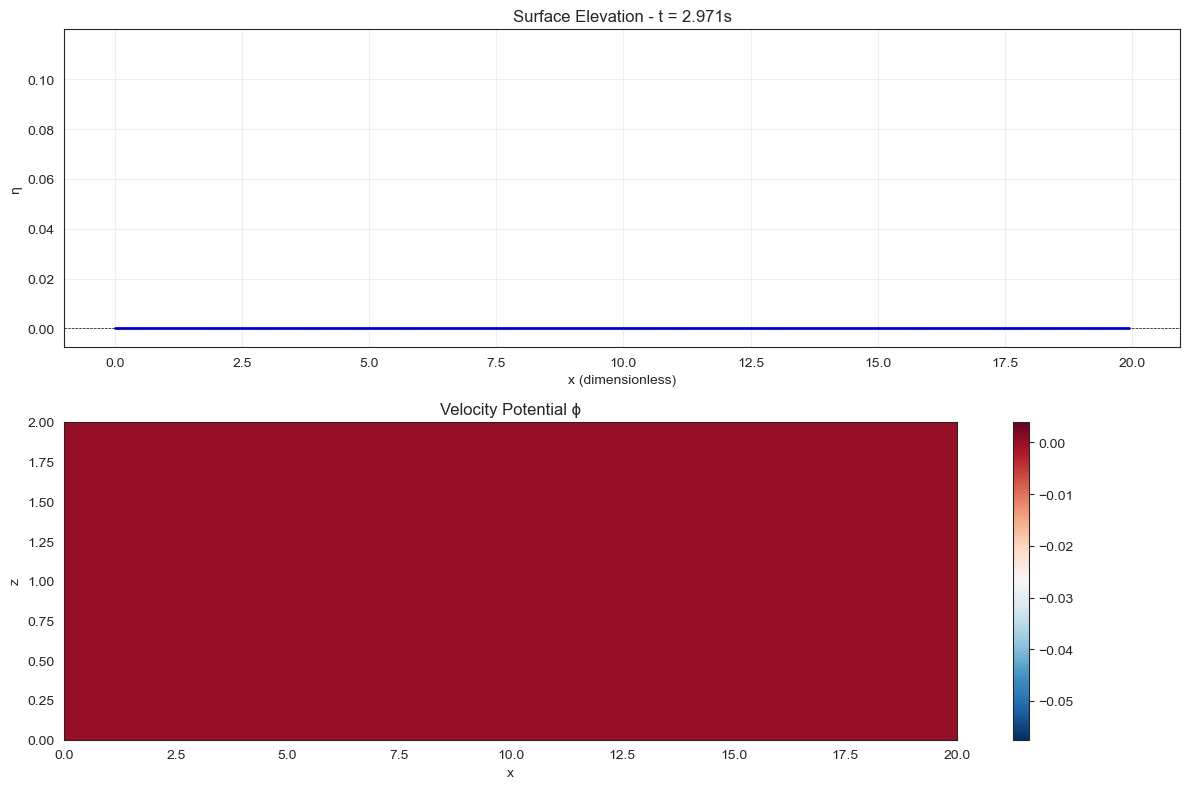

In [27]:
fig_anim, axes = plt.subplots(2, 1, figsize=(12, 8))

# Surface evolution
line_surf, = axes[0].plot(x_vec, eta_history[0], 'b-', linewidth=2)
axes[0].fill_between(x_vec, 0, eta_history[0], alpha=0.3)
axes[0].set_xlabel('x (dimensionless)')
axes[0].set_ylabel('η')
axes[0].set_ylim([min(np.min(e) for e in eta_history)*1.2,
                  max(np.max(e) for e in eta_history)*1.2])
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
title_surf = axes[0].set_title(f'Surface Elevation - t = {time_points[0]:.3f}s')

# Potential field
vmin = min(np.min(p) for p in phi_history)
vmax = max(np.max(p) for p in phi_history)
im_phi = axes[1].imshow(phi_history[0], origin='lower', extent=[0, L, 0, D],
                        aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
axes[1].set_title('Velocity Potential ϕ')
plt.colorbar(im_phi, ax=axes[1])

def animate(frame):
    line_surf.set_ydata(eta_history[frame])
    
    for coll in axes[0].collections:
        coll.remove()
    axes[0].fill_between(x_vec, 0, eta_history[frame], alpha=0.3)
    
    im_phi.set_data(phi_history[frame])
    title_surf.set_text(f'Surface Elevation - t = {time_points[frame]:.3f}s')
    
    return line_surf, im_phi

anim = FuncAnimation(fig_anim, animate, frames=len(eta_history),
                    interval=50, blit=False, repeat=True)

writer = PillowWriter(fps=5)
anim.save('02_Surface_Dynamics_updated/Outputs/fluid_dynamics.gif', writer=writer, dpi=300)

plt.tight_layout()
plt.show()